# Corporación Favorita Time Series - Exploratory Data Analysis

***
<br>




<img src="../../reports/img/Corporación_Favorita_Logo.png" width=400 height=300 />

<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>In this second notebook we will perform an Exploratory Data Analysis. This section comes after the Data Wrangling step. This step involves creating plots and charts to understand the relationship between data and the features of that data.<p>
</div>

<br>

### Table of Contents

- [Importing Libraries](#importing)
- [Importing Data](#data)
- [Checking content of dataframes](#checking)
- [Exploratory Data Analysis](#eda)
    - [Plotting our dataframes](#plotting)
        - [Oil Prices](#oil)
        - [Transactions](#transactions)
        - [Holidays](#holidays)
        - [Products (train dataset)](#products)
    - [xxx](#saving)

<a id='importing'></a>

## Importing libraries

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tqdm
import os.path
from datetime import datetime

#Settings
sns.set()
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

<a id='data'></a>

## Importing Data

***

This dataset comes from a Kaggle competition called [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data)

There are 6 relevant datasets:
 - `train`
 - `test`
 - `items`
 - `transactions`
 - `holidays`
 - `oil`

In [3]:
train = pd.read_csv('../../data/train_clean.csv', parse_dates=['date'], date_parser=dateparse,  dtype={'id': int, 'store_nbr': int, 'item_nbr': int, 'unit_sales': float, 'onpromotion':object})
test = pd.read_csv('../../data/test.csv', parse_dates=['date'], date_parser=dateparse)
items = pd.read_csv('../../data/items.csv')
transactions = pd.read_csv('../../data/transactions.csv', parse_dates=['date'], date_parser=dateparse)
holidays = pd.read_csv('../../data/holidays.csv', parse_dates=['date'], date_parser=dateparse)
oil = pd.read_csv('../../data/oil.csv', parse_dates=['date'], date_parser=dateparse)

In [4]:
# Check the shape
train = train.drop('Unnamed: 0', axis=1).set_index('date').asfreq(freq='1D')
test = test.drop('Unnamed: 0', axis=1).set_index('date').asfreq(freq='1D')
items = items.drop('Unnamed: 0', axis=1)
transactions = transactions.drop('Unnamed: 0', axis=1).set_index('date').asfreq(freq='1D') 
holidays = holidays.drop('Unnamed: 0', axis=1).set_index('date') 
oil = oil.set_index('date').asfreq(freq='1D')

In [5]:
train.onpromotion.replace(to_replace='False',value=False, inplace=True)

In [6]:
#List of dataframes
dataframes = {'Train':train, 'Test':test, 'Items':items, 'Holidays': holidays, 'Oil':oil, 'Transactions': transactions}

In [328]:
train.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2013-01-02,578,1,103665,2.0,No Info
2013-01-02,579,1,105574,8.0,No Info
2013-01-02,580,1,105575,15.0,No Info
2013-01-02,581,1,105577,2.0,No Info
2013-01-02,582,1,105737,2.0,No Info


In [327]:
test.head()

,unit_sales
date,
2017-01-02,1.0
2017-01-02,3.0
2017-01-02,1.0
2017-01-02,1.0
2017-01-02,2.0


<a id='checking'></a>

<a id='definition'></a>

## Checking the content of our dataframes

***

It will be useful to see what information we have at our disposal

In [30]:
for key, value in dataframes.items():
    print(key)
    print(value.columns)
    print()

Train
Index(['id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')

Test
Index(['id', 'store_nbr', 'item_nbr', 'onpromotion'], dtype='object')

Items
Index(['item_nbr', 'family', 'class', 'perishable'], dtype='object')

Holidays
Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

Oil
Index(['price'], dtype='object')

Transactions
Index(['store_nbr', 'transactions'], dtype='object')



In [39]:
train.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2013-01-02,578,1,103665,2.0,No Info
2013-01-02,579,1,105574,8.0,No Info
2013-01-02,580,1,105575,15.0,No Info
2013-01-02,581,1,105577,2.0,No Info
2013-01-02,582,1,105737,2.0,No Info


In [38]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103520,GROCERY I,1028,0
3,103665,BREAD/BAKERY,2712,1
4,105574,GROCERY I,1045,0


In [19]:
items.family.unique()

array(['GROCERY I', 'BREAD/BAKERY', 'DELI', 'CLEANING', 'POULTRY',
       'PERSONAL CARE', 'LINGERIE', 'BEVERAGES', 'AUTOMOTIVE', 'DAIRY',
       'EGGS', 'GROCERY II', 'MEATS', 'FROZEN FOODS', 'HOME APPLIANCES',
       'SEAFOOD', 'PREPARED FOODS', 'LIQUOR,WINE,BEER', 'BEAUTY',
       'HARDWARE', 'LAWN AND GARDEN', 'PRODUCE', 'HOME AND KITCHEN II',
       'HOME AND KITCHEN I', 'MAGAZINES', 'HOME CARE', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'CELEBRATION',
       'SCHOOL AND OFFICE SUPPLIES', 'LADIESWEAR', 'BOOKS'], dtype=object)

In [36]:
print('Example items class: ', items['class'].unique()[0:10])
print('Length class: ',len(items['class'].unique()))
print('Example items item_number: ', items['item_nbr'].unique()[0:10])
print('Length item number:', len(items['item_nbr'].unique()))

Example items class:  [1093 1067 1028 2712 1045 1034 1044 1092 1032 1030]
Length class:  313
Example items item_number:  [ 96995  99197 103520 103665 105574 105575 105577 105693 105737 105857]
Length item number: 3567


In [37]:
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
2012-12-06,Holiday,Local,Quito,Fundacion de Quito,False
2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False


In [40]:
transactions.head()

,store_nbr,transactions
date,,
2013-01-02,1,2111
2013-01-03,1,1833
2013-01-04,1,1863
2013-01-05,1,1509
2013-01-06,1,520


<a id='eda'></a>

## EDA - First steps

***

In [7]:
#we can specify a predetermined style
print(plt.style.available)

#choose one
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<a id='plotting'></a>

## Plotting our dataframes

<a id='oil'></a>

### Oil Prices

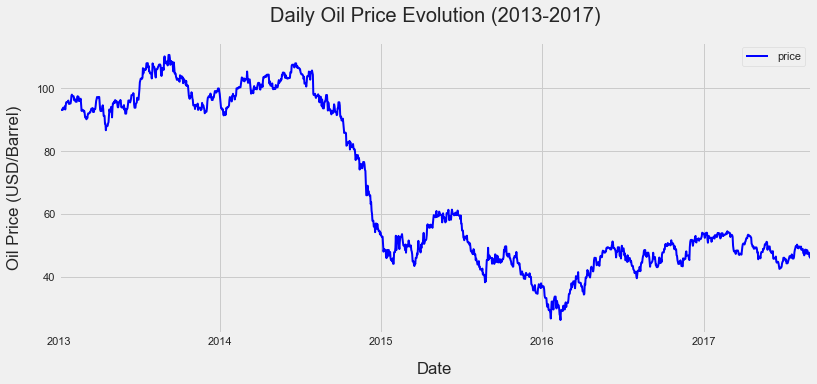

In [92]:
# We plot the daily oil price change
ax = oil.plot(color='blue', figsize=(12,5), linewidth=2)

# Labeling
ax.set_title('Daily Oil Price Evolution (2013-2017)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Oil Price (USD/Barrel)', labelpad=15)

# Show and save plot
plt.savefig('img/Oil/Daily_Oil_Price_Evolution.png', bbox_inches='tight',transparent=True, )
plt.show()

<a id='transactions'></a>

### Transactions

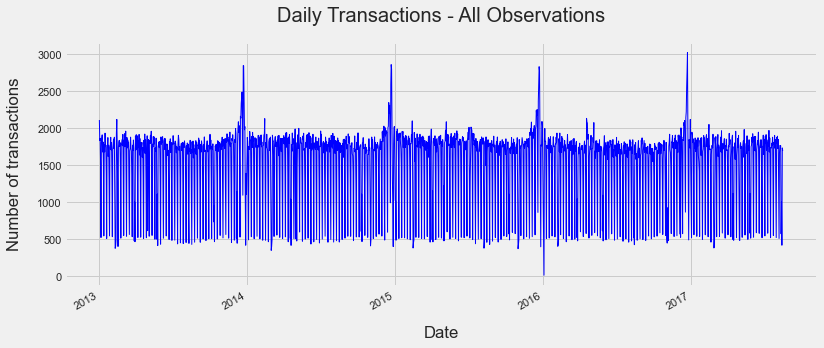

In [93]:
# We plot the daily oil price change
ax = transactions['transactions'].plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - All Observations',pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_All.png', bbox_inches='tight',transparent=True, )
plt.show()

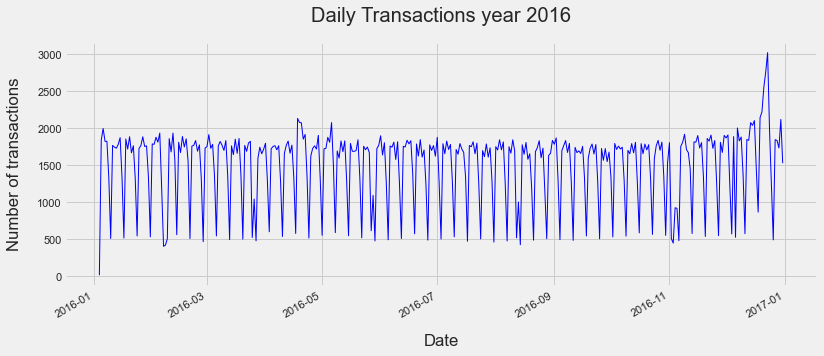

In [94]:
# We plot the daily oil price change
ax = transactions['2016-01-01':'2016-12-31']['transactions'].plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions year 2016', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_2016.png', bbox_inches='tight',transparent=True, )
plt.show()

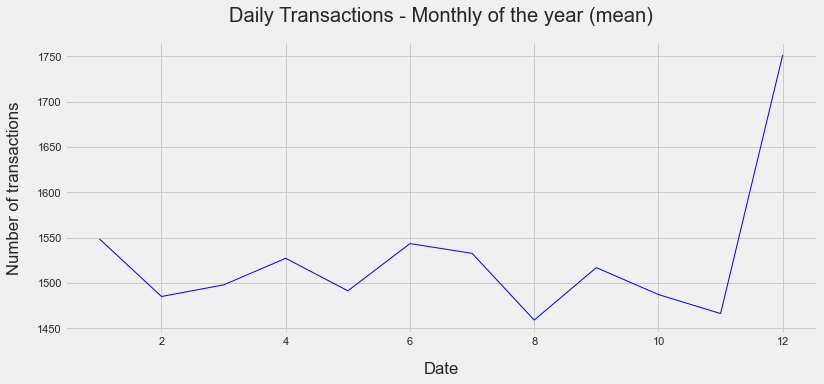

In [95]:
# Get month for each dates in the index
transactions_months = transactions.index.month
transactions_by_months = transactions['transactions'].groupby(transactions_months).mean()

# Plot
ax = transactions_by_months.plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - Monthly of the year (mean)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_Month.png', bbox_inches='tight',transparent=True, )
plt.show()

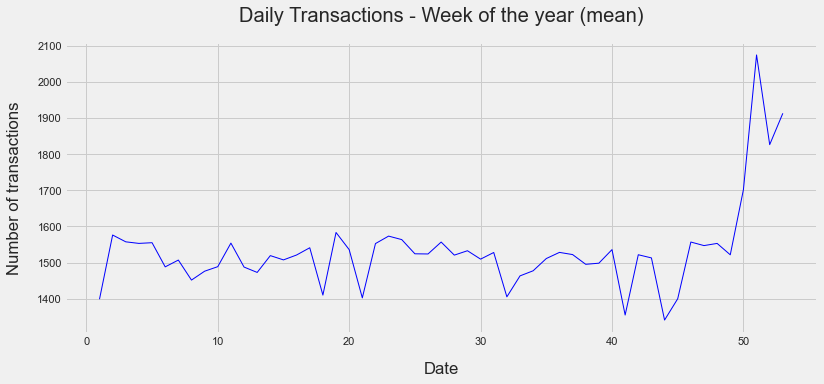

In [96]:
# Get week for each dates in the index
transactions_months = transactions.index.isocalendar().week
transactions_by_months = transactions['transactions'].groupby(transactions_months).mean()

# Plot
ax = transactions_by_months.plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - Week of the year (mean)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_Week.png', bbox_inches='tight',transparent=True, )
plt.show()

<ipython-input-97-dedf75a592ac>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


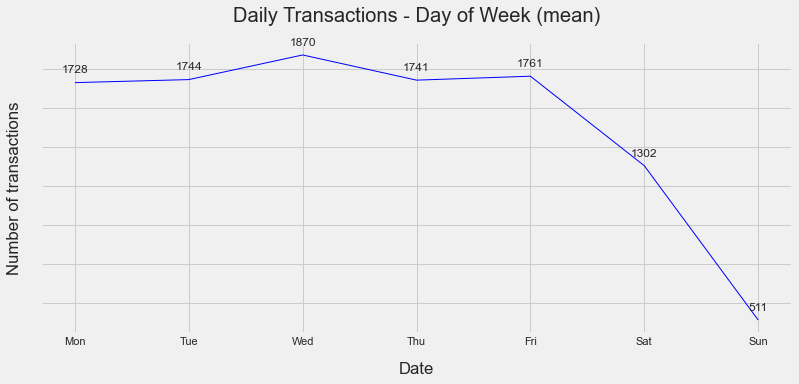

In [97]:
# Get dow for each dates in the index
transactions_dow = transactions.index.dayofweek
transactions_dow = transactions['transactions'].groupby(transactions_dow).mean()

# Plot
ax = transactions_dow.plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - Day of Week (mean)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)
ax.set_yticklabels('')
ax.set_xticklabels(labels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for i, v in enumerate(transactions_dow):
    ax.text(i, v+50, "%d" %v, ha="center", fontsize=12)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_Dow.png', bbox_inches='tight',transparent=True, )
plt.show()

In [84]:
dataframes.keys()

dict_keys(['Train', 'Test', 'Items', 'Holidays', 'Oil', 'Transactions'])

<a id='holidays'></a>

### Holidays

In [90]:
holidays['year'] = holidays.index.year

In [104]:
holidays = holidays.iloc[2:]

In [115]:
holidays.index.month

Int64Index([ 1,  1,  1,  2,  2,  4,  5,  5,  5,  5,
            ...
            11, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='date', length=171)

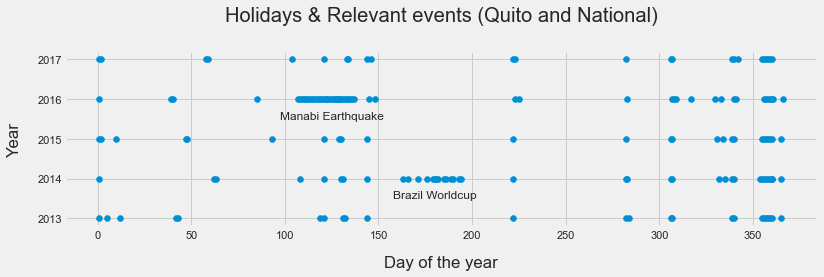

In [159]:
# We plot the daily oil price change
fig, ax = plt.subplots(figsize=(12,3))
colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}
ax.scatter(holidays.index.dayofyear, holidays['year'])

# Labeling
ax.set_title('Holidays & Relevant events (Quito and National)', pad=30)
ax.set_xlabel('Day of the year', labelpad=15)
ax.set_ylabel('Year', labelpad=15)

ax.text(125, 2015.5, 'Manabi Earthquake', ha="center", fontsize=12)
ax.text(180, 2013.5, 'Brazil Worldcup', ha="center", fontsize=12)
    
# Show and save plot
plt.savefig('img/Holidays/Holiday_dates_plotted.png', bbox_inches='tight',transparent=True, )
plt.show()

In [154]:
holidays['2014-06-12':'2014-06-30']

,type,locale,locale_name,description,transferred,year
date,,,,,,
2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False,2014
2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False,2014
2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False,2014
2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,2014
2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2014
2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2014
2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2014


In [148]:
holidays['2016-04-16':'2016-04-20']

,type,locale,locale_name,description,transferred,year
date,,,,,,
2016-04-16,Event,National,Ecuador,Terremoto Manabi,False,2016
2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False,2016
2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False,2016
2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False,2016
2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False,2016


<a id='products'></a>

### Products

There are many products and we cannot analyze them all together but we can create functions that would allow us to drill down on each of them if we need to

In [9]:
choosen_product = 105574
items[items['item_nbr'] == choosen_product]

,item_nbr,family,class,perishable
4,105574,GROCERY I,1045,0


We can also group our products by "family". In the next lines of code we merge the "items" and "train" dataframes

In [261]:
item_family = train.drop(['id','store_nbr','onpromotion'], axis=1)
item_family = item_family.reset_index().merge(items, on='item_nbr')
item_family = item_family.drop(['item_nbr','class','perishable'],axis=1)
item_family = item_family.set_index('date')

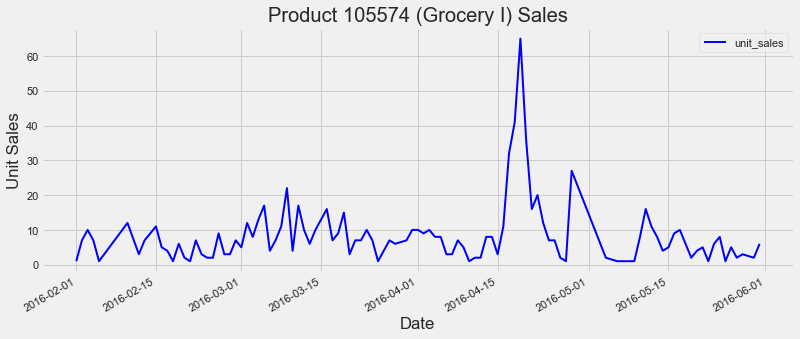

In [10]:
data = train[train['item_nbr'] == choosen_product][['unit_sales']]

ax = data['2016-02-01':'2016-05-31'].plot(color='blue', figsize=(12,5), linewidth=2)

ax.set_title('Product 105574 (Grocery I) Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Unit Sales')

# Show plot
plt.savefig('img/Products/Product_{}_Sales_Example.png'.format(choosen_product), bbox_inches='tight',transparent=True, )
plt.show()

In [14]:
def item_time_series(product,title, start_date='2013-01-01', finish_date='2017-08-15', save_as='time_series_plot', 
                     hline_kwargs=None, vline_kwargs=None, 
                     hregion_kwargs=None, vregion_kwargs=None):
    
    '''Creates a timeseries plot from the items in the store's catalog'''
    
    #data
    data = train[train['item_nbr'] == product][['unit_sales']]

    #plot
    ax = data[start_date:finish_date].plot(color='blue', figsize=(12,5), linewidth=2)

    #design
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Unit Sales')
    
    #annotations
    # Add a red vertical line
    if hline_kwargs == None:
        pass
    else:
        ax.axvline(**vline_kwargs)

    # Add a green horizontal line
    if vline_kwargs == None:
        pass
    else:
        ax.axhline(**hline_kwargs)
        
    # Add a vertical red shaded region
    if vregion_kwargs == None:
        pass
    else:
        ax.axvspan(**vregion_kwargs)

    # Add a horizontal green shaded region
    if hregion_kwargs == None:
        pass
    else:
        ax.axhspan(**hregion_kwargs)

    # Show plot
    plt.savefig('img/Products/'+save_as+'.png', bbox_inches='tight',transparent=True)
    plt.show()

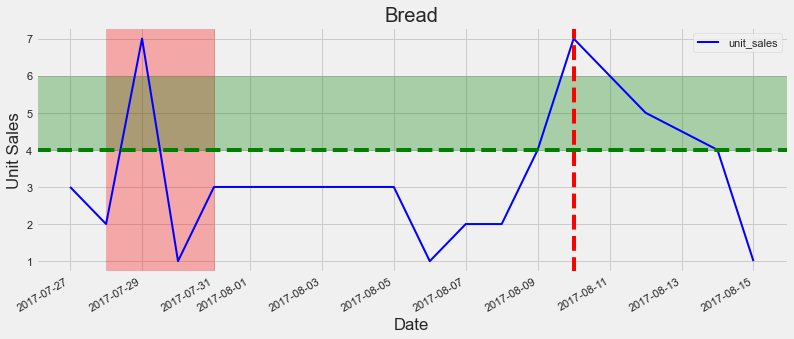

In [15]:
item_time_series(2116416,'Bread', start_date='2017-01-01', finish_date='2017-08-15', save_as='bread_sales_example',
                hline_kwargs={'y':4, 'color':'green', 'linestyle':'--'},
                vline_kwargs={'x':'2017-08-10', 'color':'red', 'linestyle':'--'},
                vregion_kwargs={'xmin':'2017-07-28', 'xmax':'2017-07-31', 'color':'red', 'alpha':0.3},
                hregion_kwargs={'ymin':4, 'ymax':6, 'color':'green', 'alpha':0.3})
                

In [16]:
def item_time_series_ma(product,title, rolling_time_span=7, mean_std=2,
                     start_date='2013-01-01', finish_date='2017-08-15', save_as='time_series_plot'):
    
    '''Creates a timeseries plot from the items in the store's catalog'''
    
    #data
    data = train[train['item_nbr'] == product][['unit_sales']]

    # Compute the rolling mean of the unit sales
    ma = data.rolling(window=rolling_time_span).mean()

    # Compute the rolling standard deviation of the unit sales
    mstd = data.rolling(window=rolling_time_span).std()

    # Add the upper bound column to the ma DataFrame
    ma['upper'] = ma['unit_sales'] + (mean_std * mstd['unit_sales'])

    # Add the lower bound column to the ma DataFrame
    ma['lower'] = ma['unit_sales'] - (mean_std * mstd['unit_sales'])
    ma['lower'] = ma['lower'].apply(lambda x: x*0 if x < 0 else x)                                   

    # Plot the content of the ma DataFrame
    ax = ma[start_date:finish_date].plot(linewidth=0.8, fontsize=10, figsize=(12,5))

    # Specify labels, legend
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Unit Sales')
    
    # Show plot
    plt.savefig('img/Products/'+save_as+'.png', bbox_inches='tight',transparent=True)
    plt.show()

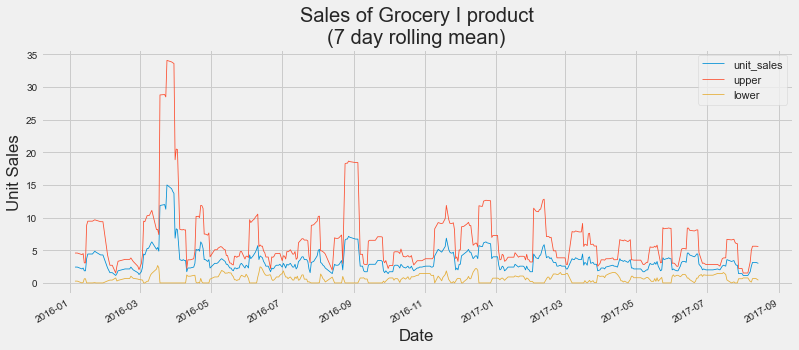

In [314]:
item_time_series_ma(105737,'Sales of Grocery I product\n(7 day rolling mean)', rolling_time_span=7, mean_std=1,
                     start_date='2016-01-01', finish_date='2017-08-15', save_as='Groceries_Sales')

In [18]:
choosen_product = 105737
items[items['item_nbr'] == choosen_product]

,item_nbr,family,class,perishable
8,105737,GROCERY I,1044,0


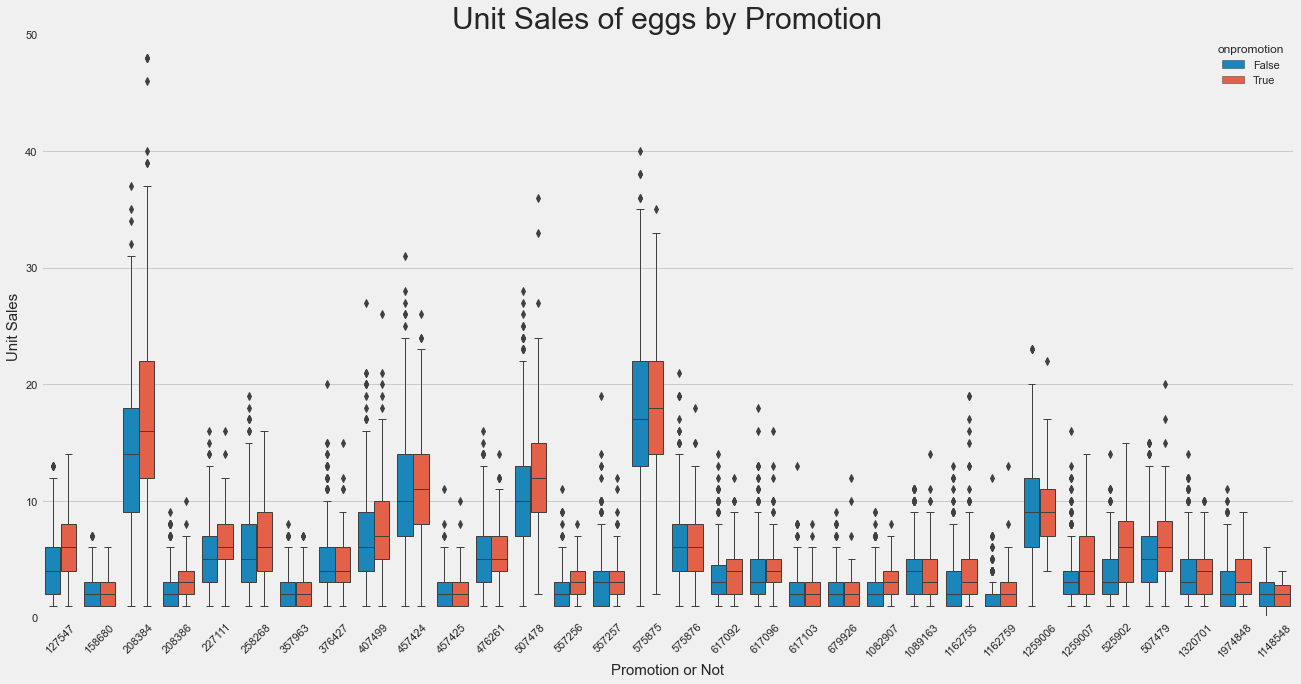

In [250]:
#data
product = 'EGGS'
family = items[items['family'] == product].item_nbr.tolist()
data = train[(train['item_nbr'].isin(family)) & (train['onpromotion'] != 'No Info')]

#size
plt.figure(figsize=(20,10))

# Generate a boxplot
ax = sns.boxplot(y='unit_sales', x='item_nbr', hue='onpromotion', data=data, linewidth=1) 

# Set the labels and display the plot
ax.set_title('Unit Sales of {} by Promotion'.format(product.casefold()), size=30)
ax.set_xlabel('Promotion or Not', fontsize=15)
ax.set_ylabel('Unit Sales', fontsize=15)
ax.set_xticklabels(labels=data['item_nbr'].unique().tolist(), rotation=45, ha='center')
ax.set_ylim(bottom=0, top=50)

# Show plot
plt.savefig('img/Eggs_Sales.png', bbox_inches='tight',transparent=True)
plt.show()

In [237]:
df = train.merge(items, on='item_nbr', how='left')

In [282]:
family_list = df.sort_values(by='unit_sales', ascending=False)['family'].unique().tolist()
family_list = [family_list[i:i + 8] for i in range(0, len(family_list), 8)]

In [287]:
data['unit_sales'].max()

15.0

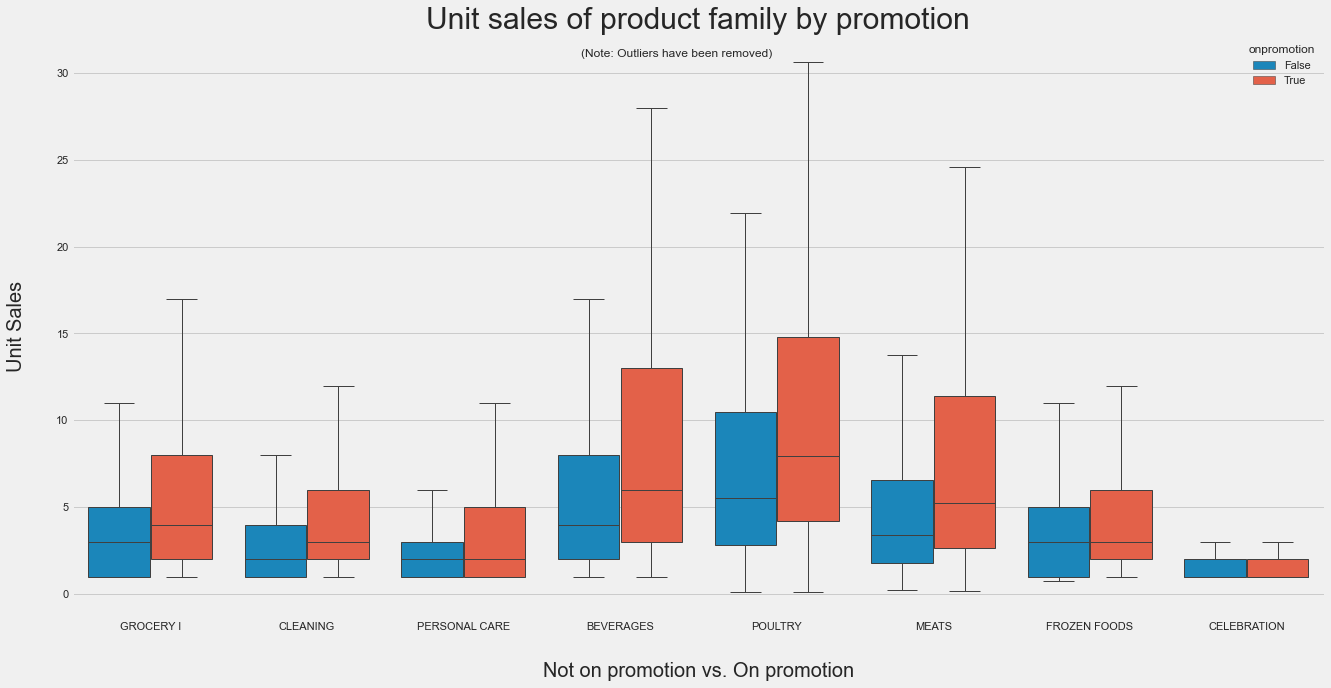

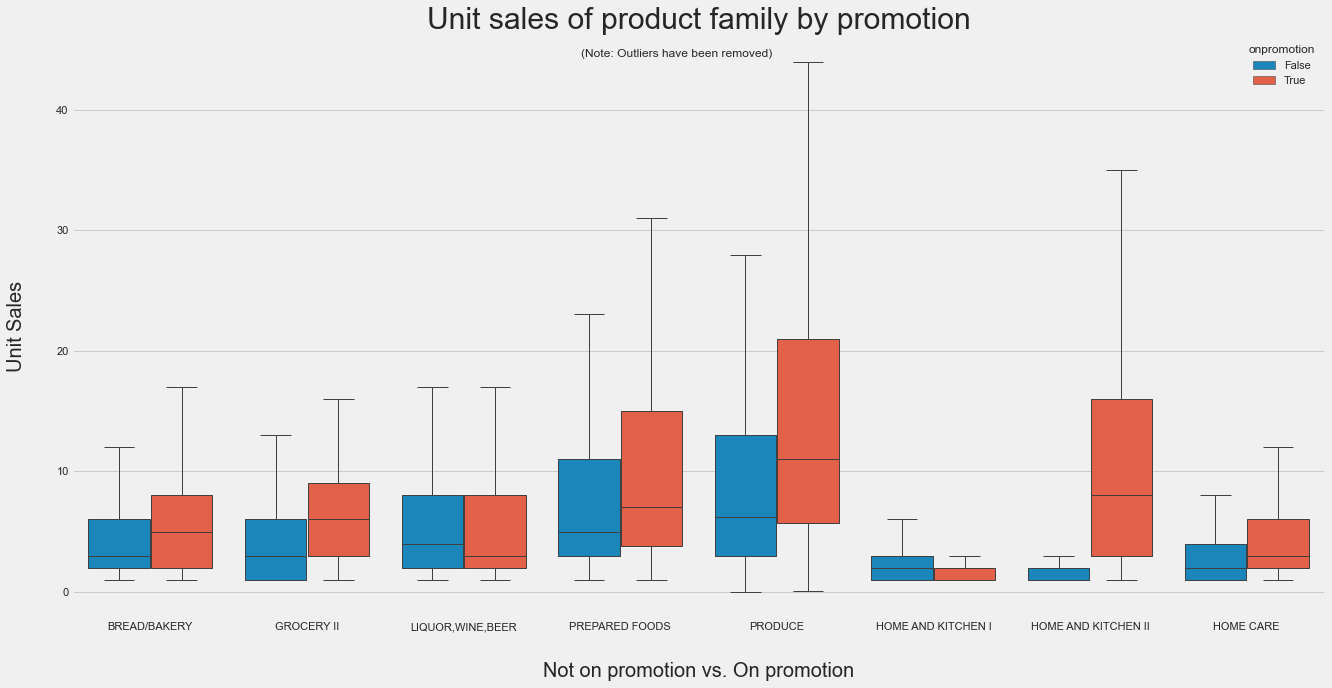

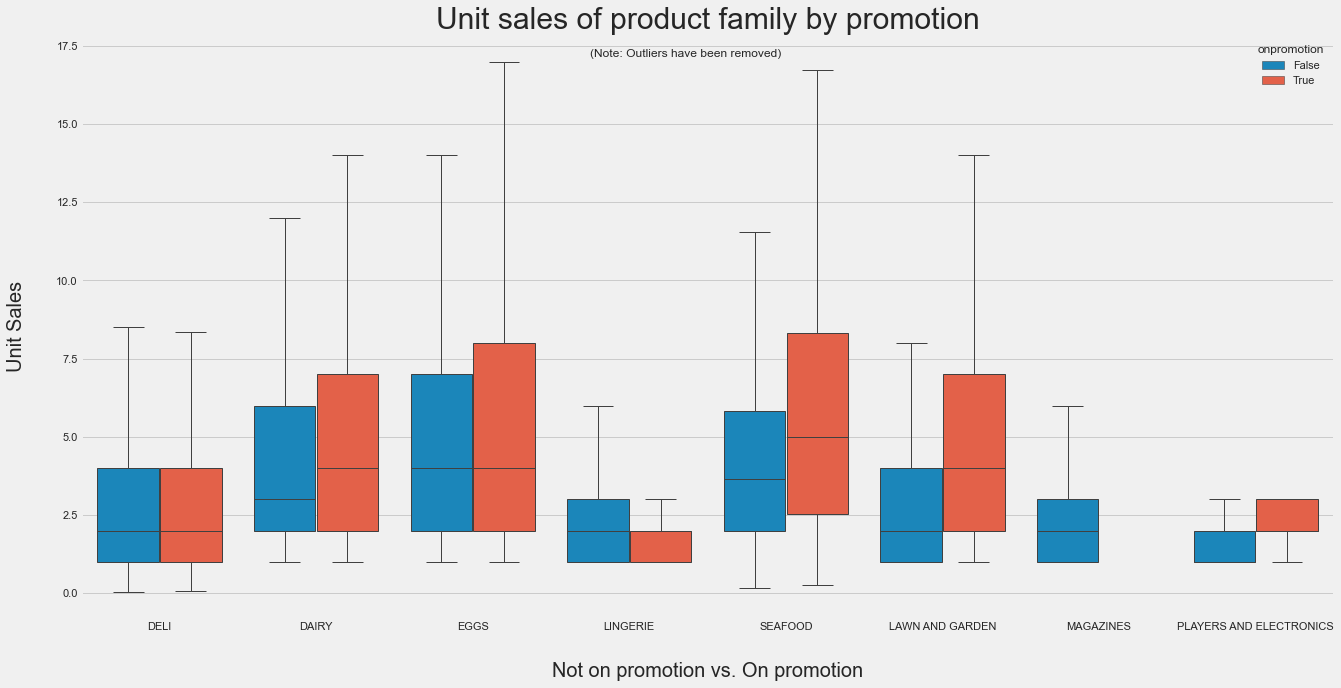

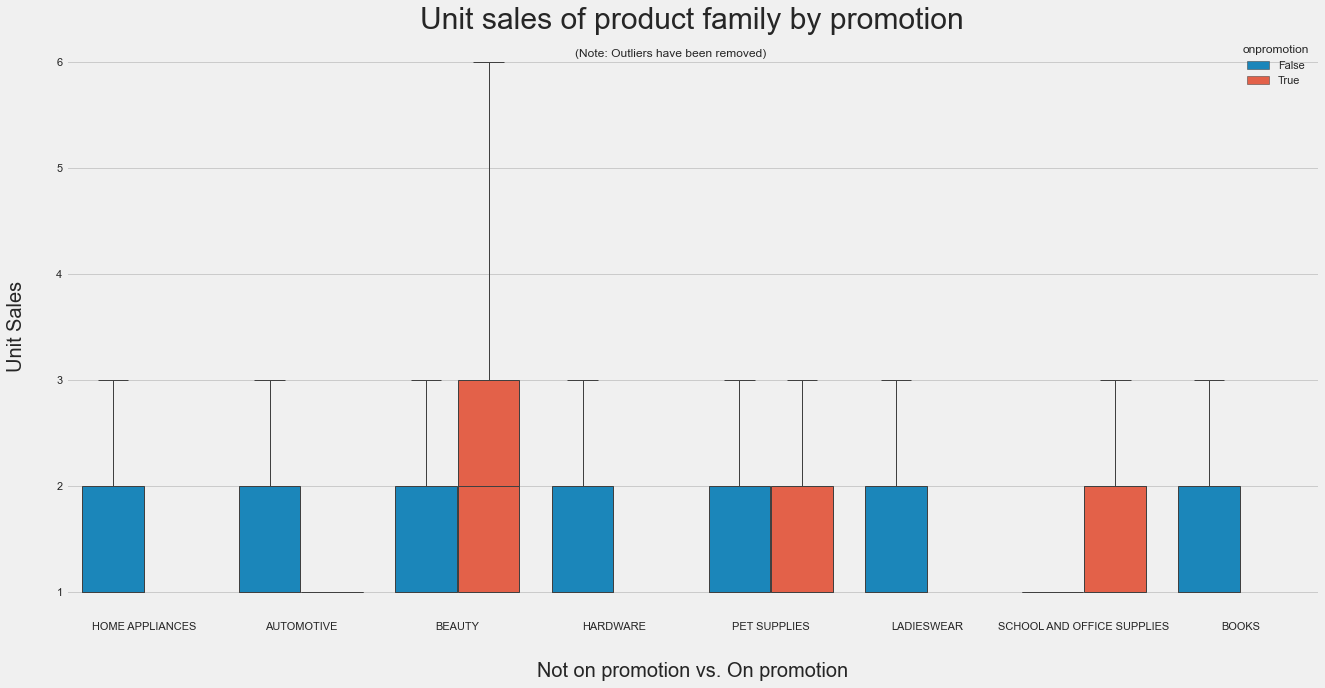

In [292]:
for number, group in enumerate(family_list):
    
    #data
    data = df[(df['onpromotion'] != 'No Info') & (df['family'].isin(group)) & (df['unit_sales'] > 0)]
    
    #size
    plt.figure(figsize=(20,10))

    # Generate a boxplot
    ax = sns.boxplot(y='unit_sales', x='family', hue='onpromotion', data=data, showfliers=False, linewidth=1) 

    # Set the labels and display the plot
    ax.set_title('Unit sales of product family by promotion'.format(product.casefold()), size=30)
    plt.figtext(.5,.85,'(Note: Outliers have been removed)',fontsize=12,ha='center')
    ax.set_xlabel('Not on promotion vs. On promotion', fontsize=20, labelpad=30)
    ax.set_ylabel('Unit Sales', fontsize=20,labelpad=30)
    
    plt.savefig('img/Promotion/product_family_promotion_group_'+str(number)+'.png', bbox_inches='tight',transparent=True)
    plt.show()

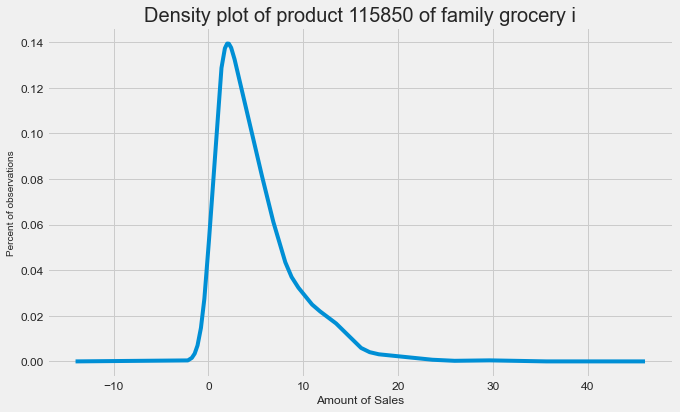

In [328]:
select_product = 115850

# Display density plot
ax = df[df['item_nbr']==select_product]['unit_sales'].plot(kind='density', linewidth=4, fontsize=12, figsize=(10,6))
product_id = df[df['item_nbr']==select_product]['item_nbr'].head(1).tolist()
family_name = df[df['item_nbr']==select_product]['family'].head(1).tolist()

# Annotate
ax.set_title('Density plot of product {} of family {}'.format(product_id[0], family_name[0].casefold()), size=20)
ax.set_xlabel('Amount of Sales', fontsize=12)
ax.set_ylabel('Percent of observations', fontsize=10)

plt.savefig('img/Products/'+family_name[0]+' '+str(product_id[0])+'.png', bbox_inches='tight',transparent=True)
plt.show()


## Autocorrelation and Partial Autocorrelation

In [283]:
# Import required libraries
from statsmodels.graphics import tsaplots

def autocorrelation_plots(dataframe, column, title_text=None, n_lags=30, save=True, save_as='acf_pacf.png'):
    
    if sum(dataframe[column].isna()) > 0:
        print('Missing values have been dropped')
        print()
        
    fig, ax = plt.subplots(2, sharex=True, figsize=(12,8))
    ax0 = tsaplots.plot_acf(dataframe[column].dropna(), lags=n_lags, ax=ax[0], title='Autocorrelation '+title_text)
    ax1 = tsaplots.plot_pacf(dataframe[column].dropna(), lags=n_lags, ax=ax[1], title='Partial Autocorrelation '+title_text)

    # Show plot
    if save == True:
        plt.savefig(save_as, bbox_inches='tight',transparent=True)
    else:
        pass
    
    plt.show()

Missing values have been dropped



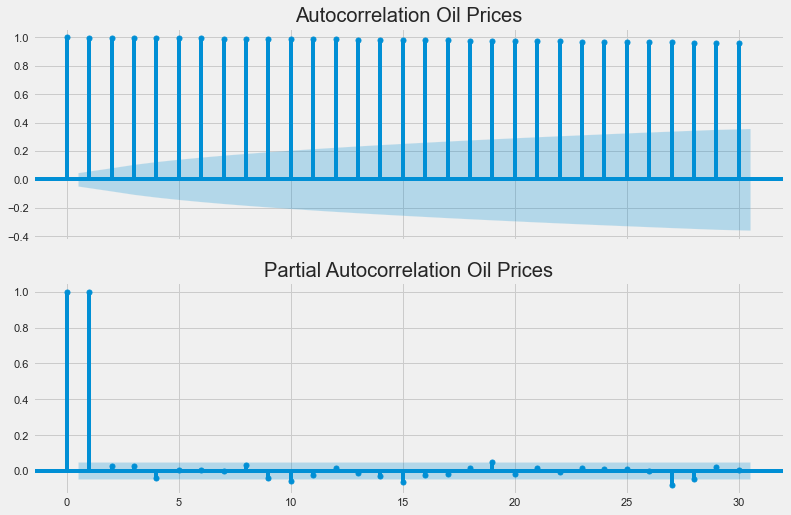

In [284]:
autocorrelation_plots(oil,'price', title_text='Oil Prices', n_lags=30, save_as='img/Oil/ACF_PACF.png')

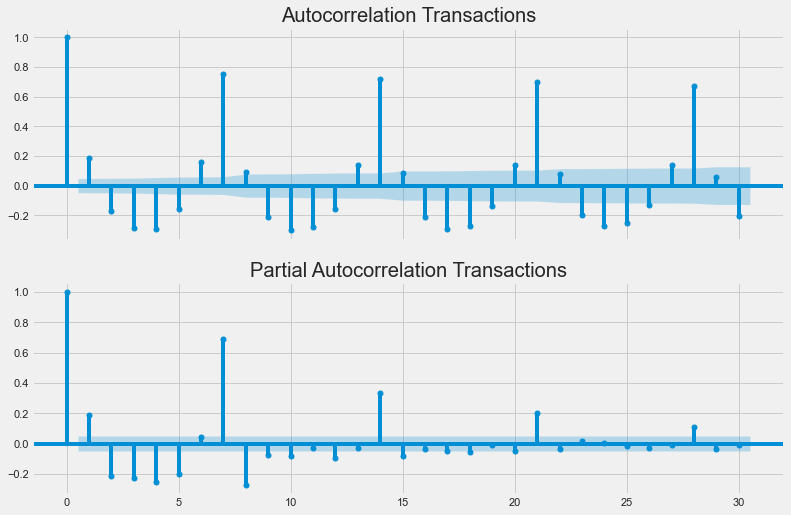

In [286]:
autocorrelation_plots(transactions,'transactions', title_text='Transactions', 
                      n_lags=30, save_as='img/Transactions/ACF_PACF.png')

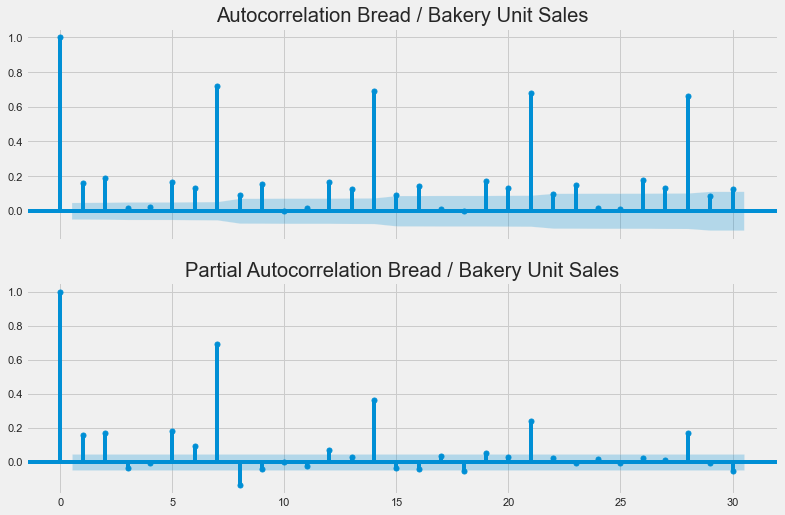

In [291]:
data = item_family[item_family['family']=='BREAD/BAKERY'].groupby(axis=0, level=0).sum()

autocorrelation_plots(data,'unit_sales', title_text='Bread / Bakery Unit Sales', n_lags=30,save=True, save_as='img/Products/ACF_PACF_Deli.png')

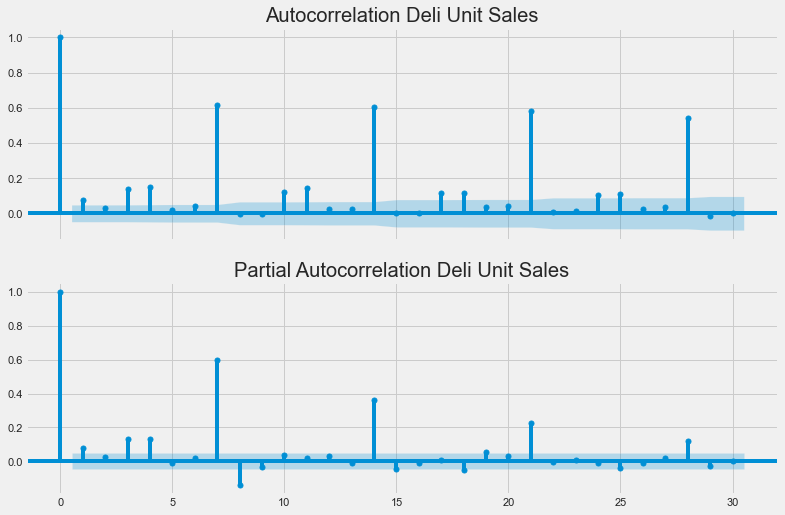

In [290]:
data = item_family[item_family['family']=='DELI'].groupby(axis=0, level=0).sum()

autocorrelation_plots(data,'unit_sales', title_text='Deli Unit Sales', n_lags=30,save=True, save_as='img/Products/ACF_PACF_Deli.png')


## Seasonality, Trend, and Noise
***

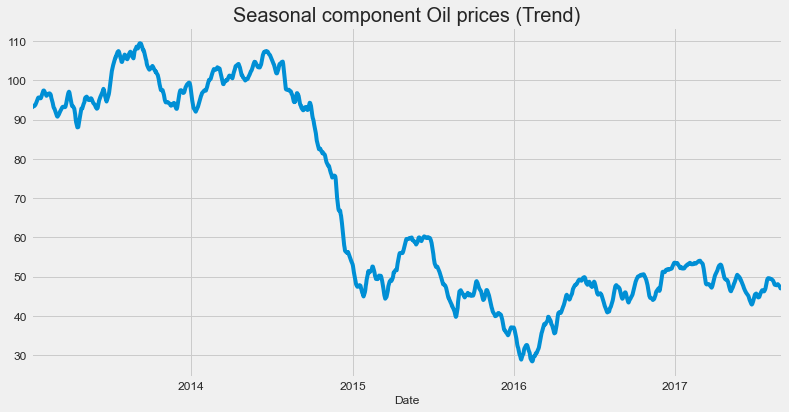

In [308]:
import statsmodels.api as sm

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(oil.iloc[1:])

# Print the seasonality component
seasonal = decomposition.seasonal
observed = decomposition.observed
trend = decomposition.trend
residuals = decomposition.resid

# Plot the values of the trend
ax = trend.plot(figsize=(12, 6), fontsize=12)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Seasonal component Oil prices (Trend)', fontsize=20)
plt.show()

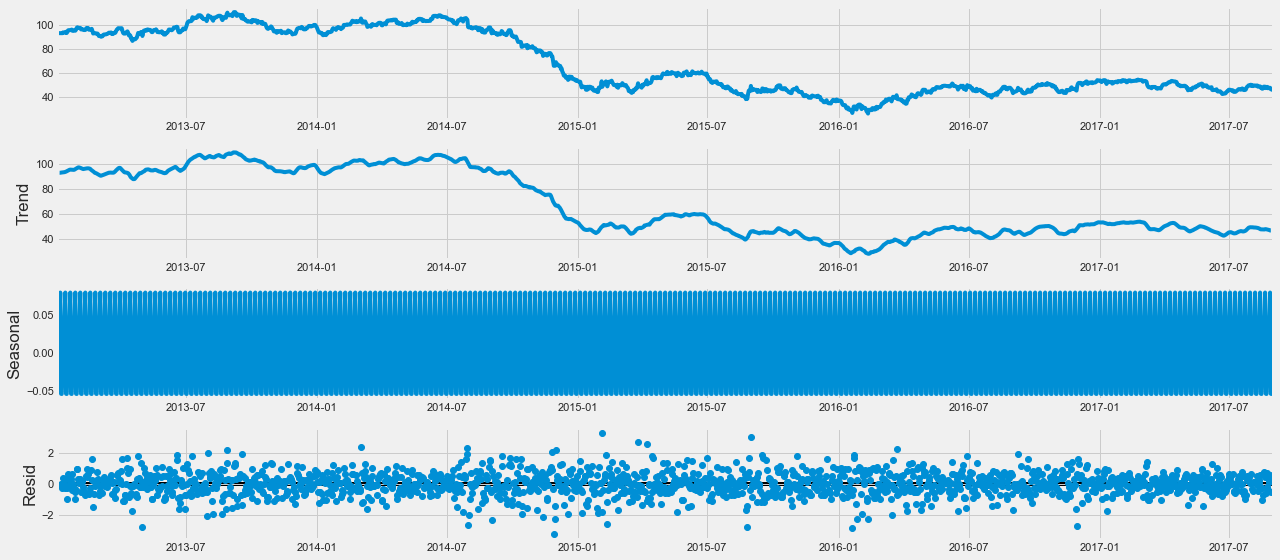

In [309]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(oil.iloc[1:])
fig = decomposition.plot()

plt.show()

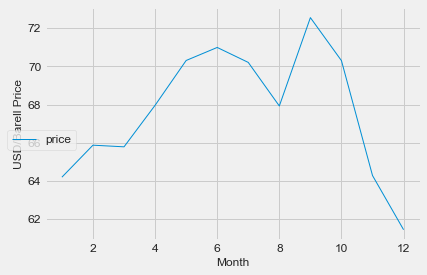

In [295]:
oil_months = oil.index.month

# Compute the mean unemployment rate for each year
oil_by_months = oil.groupby(oil_months).mean()

# Plot the mean unemployment rate for each year
ax = oil_by_months.plot(fontsize=12, linewidth=1)

# Set axis labels and legend
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('USD/Barell Price', fontsize=12)
ax.legend(bbox_to_anchor=(0.1, 0.5), fontsize=12)
plt.savefig('img/Monthly_oil_price.png', bbox_inches='tight',transparent=True)
plt.show()

In [332]:
data

,id,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2014-04-01,21657692,1,127547,11.0,False
2014-04-01,21657706,1,158680,3.0,False
2014-04-01,21657744,1,208384,17.0,False
2014-04-01,21657745,1,208386,4.0,False
2014-04-01,21657780,1,227111,9.0,False
...,...,...,...,...,...
2017-08-15,125395081,1,1082907,1.0,False
2017-08-15,125395150,1,1148548,14.0,False
2017-08-15,125395180,1,1162755,5.0,False


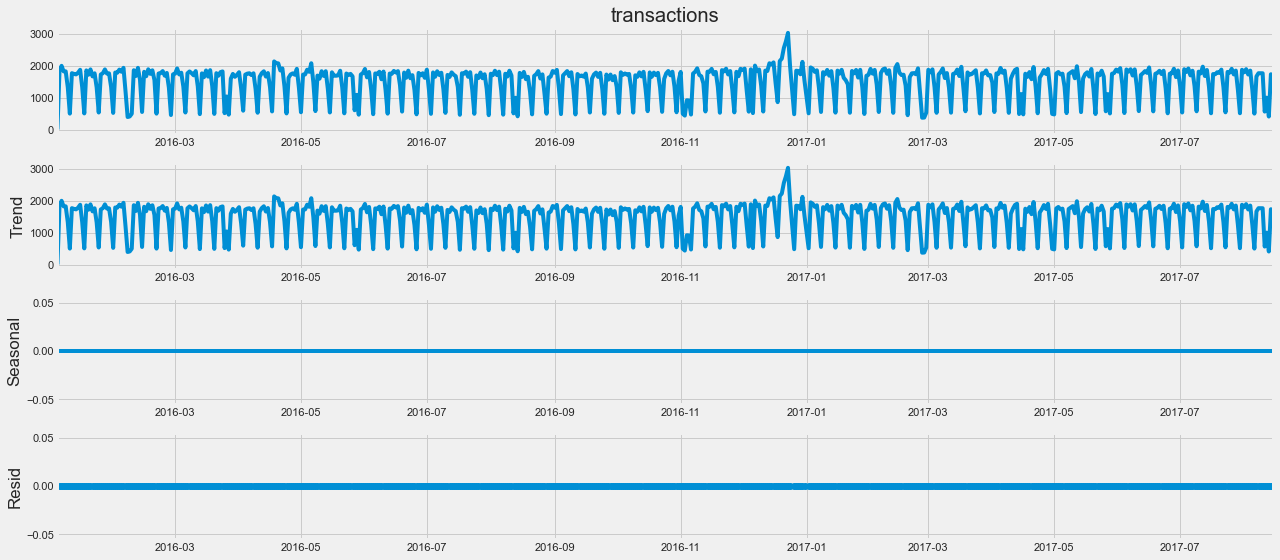

In [333]:
decomposition = sm.tsa.seasonal_decompose(transactions['2016':'2017']['transactions'], model='additive', period=1)
fig = decomposition.plot()

plt.show()

In [331]:
product = 'EGGS'
family = items[items['family'] == product].item_nbr.tolist()
data = train[(train['item_nbr'].isin(family)) & (train['onpromotion'] != 'No Info')]

decomposition = sm.tsa.seasonal_decompose(data['unit_sales'].month, model='additive', period=1)
fig = decomposition.plot()

plt.show()

AttributeError: 'Series' object has no attribute 'month'


## Clustermap
***

In [208]:
df_corr = train.drop(['id','store_nbr','onpromotion'], axis=1)
df_corr = df_corr.reset_index().merge(items, on='item_nbr')
df_corr = df_corr.drop(['item_nbr','class','perishable'],axis=1)
df_corr = df_corr.groupby(['date','family']).sum()
df_corr = df_corr.reset_index(level=1).pivot(columns='family', values='unit_sales').corr()

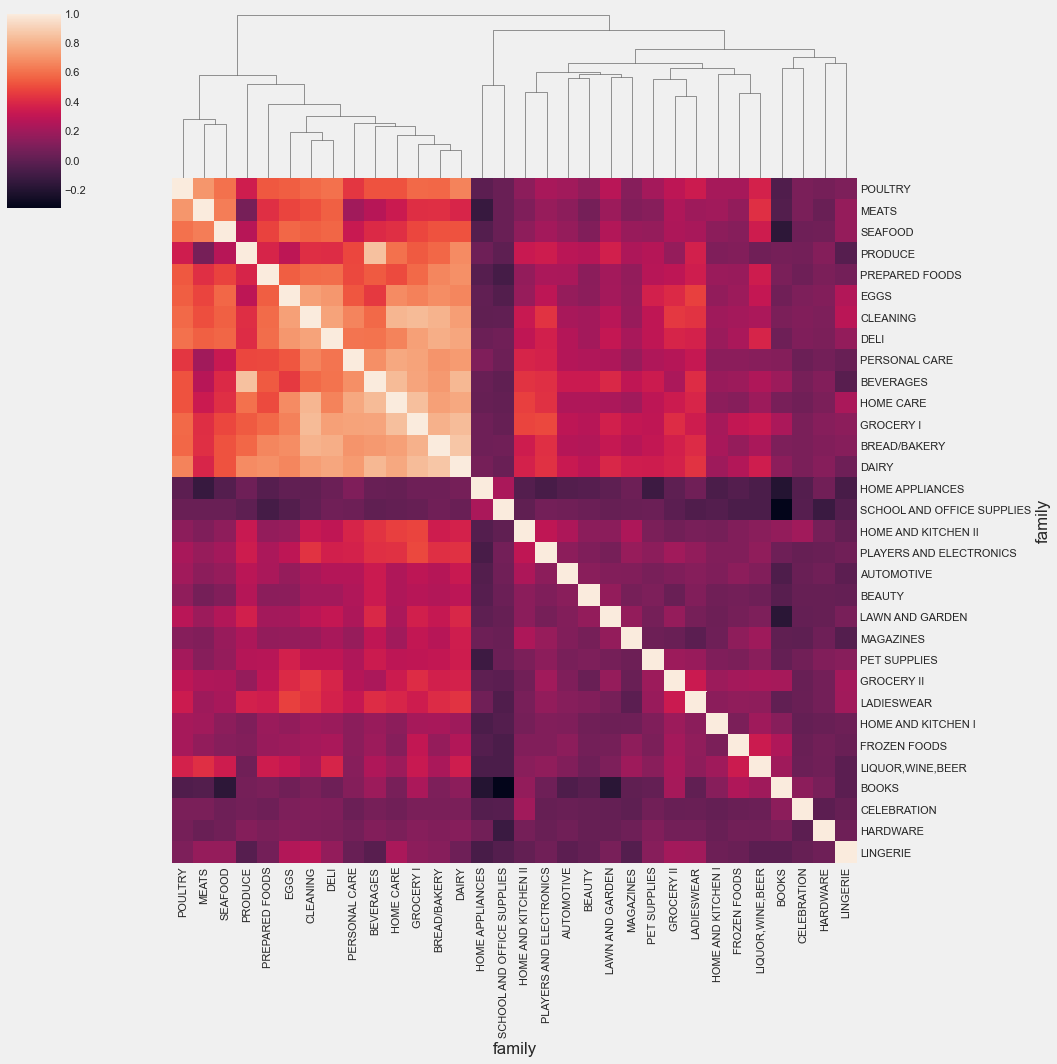

In [312]:
# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(df_corr,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(15, 15),
                    )

fig.ax_row_dendrogram.remove()

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [6]:
# Check the shape
print(holidays.shape)
print(oil.shape)
print(items.shape)
print(stores.shape)
print(test.shape)
print(transactions.shape)

try:
    print(train.shape)
except NameError:
    print(df.shape)

(350, 6)
(1218, 2)
(4100, 4)
(54, 5)
(3370464, 5)
(83488, 3)
(2562153, 6)


In [7]:
def nulls(dataframe):
    '''Checks what percent of null values are in each column'''
    for i in dataframe.columns:
        print(i,str(sum(dataframe[i].isnull())/len(dataframe)*100)+'%')

<br>

**stores.csv**

- Store metadata, including `city`, `state`, `type`, and `cluster`.
- `cluster` is a grouping of similar stores.


In [8]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [9]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
nulls(stores)

store_nbr 0.0%
city 0.0%
state 0.0%
type 0.0%
cluster 0.0%


In [11]:
stores[stores['city']=='Quito']

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
16,17,Quito,Pichincha,C,12


<br>

**train.csv**

Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
- The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
- Negative values of unit_sales represent returns of that particular item.
- The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
- Approximately 16% of the onpromotion values in this file are NaN.
    
NOTE: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.6+ GB


In [52]:
# The train dataset is very large, let's reduce it to make it manageable for a personal computer. Let's look at the first rows
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [82]:
nulls(train)

id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 17.257499459748214%


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.6+ GB


<br>

<div class='alert alert-danger'>
    For this analysis we will reduce the original dataset and keep data from 1 store
</div>

In [18]:
select_store_number = 1

In [19]:
number_store_selected = stores[stores['store_nbr'] == select_store_number]['store_nbr'][0]
city_store_selected = stores[stores['store_nbr'] == select_store_number]['city'][0]

In [20]:
# We will take the store numbers 1 to 3 as a way to simplify the dataset
if os.path.isfile('train_clean.csv') == True:
    pass
else:
    df = train[train['store_nbr'].isin([number_store_selected])] 
    df.to_csv('train_clean.csv')

In [21]:
df.shape

(2562153, 6)

In [13]:
nulls(df)

id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 18.923655222775533%


<br>

**test.csv**

- Test data, with the `date`, `store_nbr`, `item_nbr` combinations that are to be predicted, along with the `onpromotion` information.

- NOTE: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products..

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 106.1 MB


In [15]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [16]:
nulls(test)

id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
onpromotion 0.0%


In [22]:
# We will take the store numbers 1 to 3 as a way to simplify the dataset
test = test[test['store_nbr'].isin([number_store_selected])]

<br>

**items.csv**

- Item metadata, including `family`, `class`, and `perishable`.
- NOTE: Items marked as `perishable` have a score weight of 1.25; otherwise, the weight is 1.0.


In [23]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [24]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [25]:
#Not all items are present in every store, here we select the items of interest to us
items_in_selected_store = df['item_nbr'].unique().tolist()
items = items[items['item_nbr'].isin(items_in_selected_store)]

<br>

**transactions.csv**

- The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.

In [26]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [27]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [28]:
transactions = transactions[transactions['store_nbr'].isin([number_store_selected])]

In [29]:
nulls(transactions)

date 0.0%
store_nbr 0.0%
transactions 0.0%


<br>

**oil.csv**

- Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [30]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [31]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [32]:
oil.columns = ['date','price']

In [33]:
nulls(oil)

date 0.0%
price 3.5303776683087027%


In [34]:
print('There are {} null values'.format(len(oil[oil['price'].isnull() == True])))

There are 43 null values


<br>

**holidays_events.csv**

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [35]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [36]:
nulls(holidays)

date 0.0%
type 0.0%
locale 0.0%
locale_name 0.0%
description 0.0%
transferred 0.0%


In [37]:
holidays = holidays[(holidays['locale_name'] == city_store_selected) |
                     (holidays['locale'] == 'National') &
                     (holidays['date'] >= '2013-01-01')]

<br>

To understand better our data we will check how the time data is structured, are there gaps between the data we have?

In [38]:
def check_gaps(dataframe):
    '''plots a dataframe's date column and checks if there are gaps'''
    times_gaps = pd.DataFrame(dataframe.date.unique()) - pd.DataFrame(dataframe.date.unique()).shift(1)
    times_gaps.columns = ['gaps']
    plt.figure(figsize=(20,6))
    plt.scatter(x=dataframe.date.unique(), y=times_gaps.gaps.dt.days)
    plt.show()

In [39]:
#let's now check if there are any gaps in our timeseries data. We put all the datasets into a list of dataframes
dataframes = {'Train':df, 'Test':test, 'Items':items, 'Stores':stores, 'Holidays': holidays, 'Oil':oil, 'Transactions': transactions}

TRAIN
Columns:  ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']
Unique values: 1678
 First observation:  2013-01-02 00:00:00 
 Last observation:  2017-08-15 00:00:00
Gaps between observed data


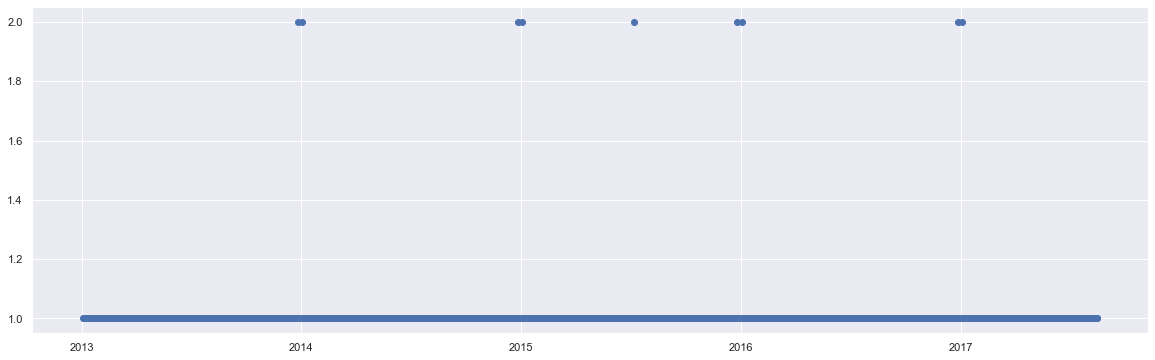

 
TEST
Columns:  ['id', 'date', 'store_nbr', 'item_nbr', 'onpromotion']
Unique values: 16
 First observation:  2017-08-16 00:00:00 
 Last observation:  2017-08-31 00:00:00
Gaps between observed data


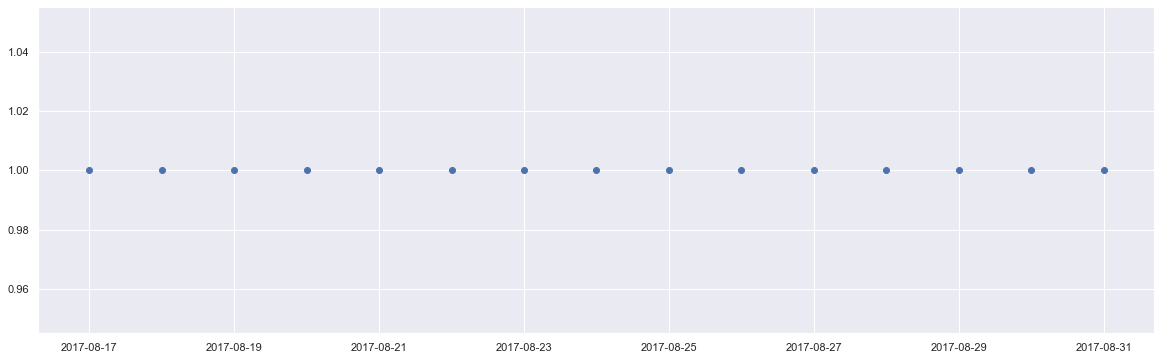

 
HOLIDAYS
Columns:  ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']
Unique values: 169
 First observation:  2012-12-05 00:00:00 
 Last observation:  2017-12-26 00:00:00
Gaps between observed data


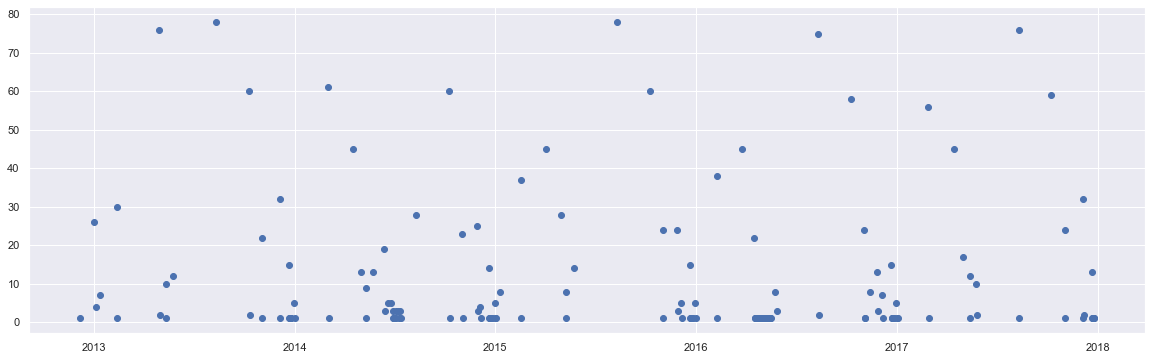

 
OIL
Columns:  ['date', 'price']
Unique values: 1218
 First observation:  2013-01-01 00:00:00 
 Last observation:  2017-08-31 00:00:00
Gaps between observed data


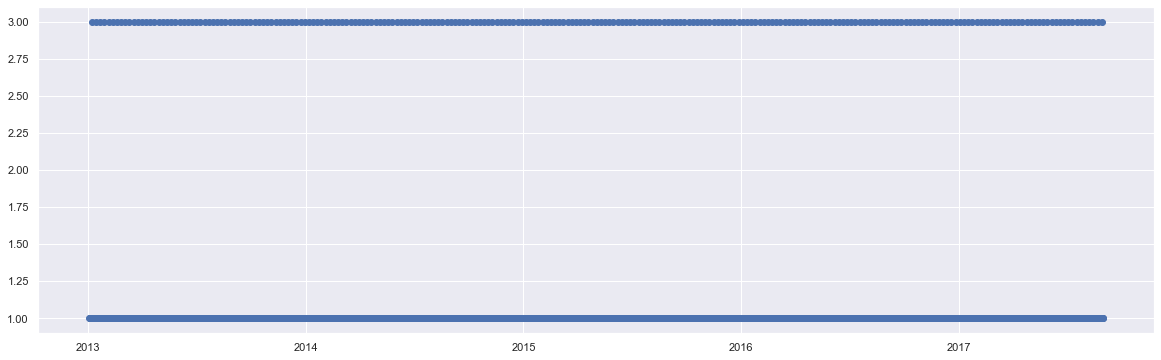

 
TRANSACTIONS
Columns:  ['date', 'store_nbr', 'transactions']
Unique values: 1676
 First observation:  2013-01-02 00:00:00 
 Last observation:  2017-08-15 00:00:00
Gaps between observed data


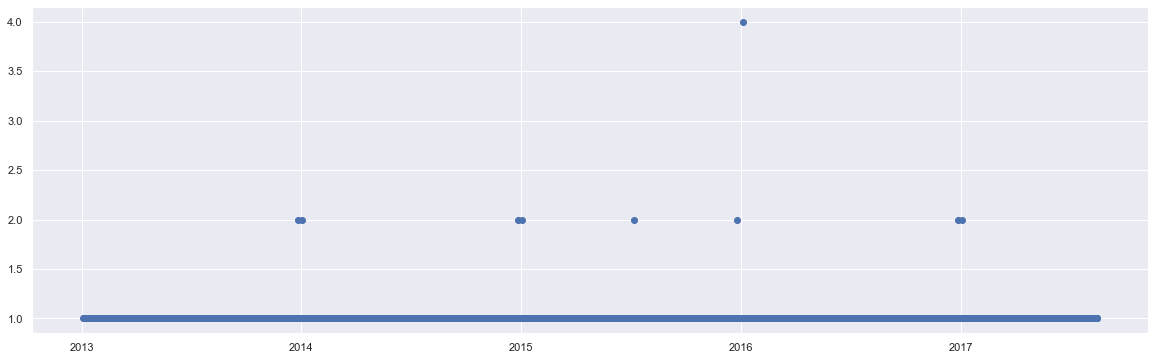

In [40]:
#we check the different dataframes to find the ones that have timeseries data
for name, data in dataframes.items():
    if 'date' in data.columns:
        print(name.upper())
        print('Columns: ', data.columns.to_list())
        print('Unique values:', len(data.date.unique()))
        first_date = min(data.date)
        last_date = max(data.date)
        print(' First observation: ', first_date,'\n','Last observation: ', last_date)
        print('Gaps between observed data')
        check_gaps(data)
        print(' ')

From the plots above we can see:
- The days the store opens are all of them except a day in late December and a date in early January. There is one exception, in mid 2015 there was also a day that store closed
- We can see that in the holiday's data there is a lot of variance between gaps, this makes sense
- The oil data shows that there are 3 gaps which corresponds to weekend data
- Transactions shows that there are even less 2 days gaps than in terms of the days that the store was opened. Maybe some transactions were recorded the day after.

<a id='cleaning'></a>

## Data Cleaning
***

In [41]:
#let's start by dealing with the null values. Only two datasources included null values our train data "on promotion" column, and the oil prices
df[df['onpromotion'].isnull()].head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,578,2013-01-02,1,103665,2.0,NaN
1,579,2013-01-02,1,105574,8.0,NaN
2,580,2013-01-02,1,105575,15.0,NaN
3,581,2013-01-02,1,105577,2.0,NaN
4,582,2013-01-02,1,105737,2.0,NaN


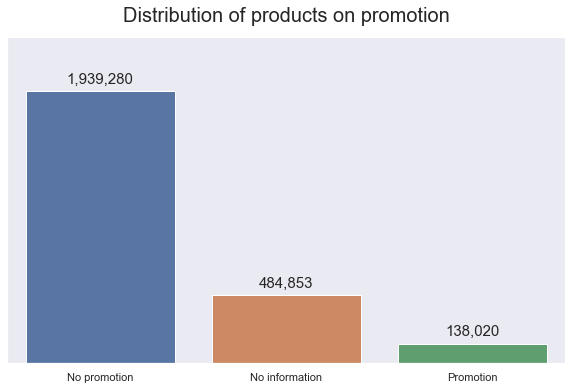

In [42]:
# for the oil prices we will first check the price evolution
plt.figure(figsize=(10,6))

#plot
ax = sns.barplot(x=['No promotion', 'No information','Promotion'], y=df['onpromotion'].fillna('No value').value_counts())

#data 
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate('{:,}'.format(round(height)), xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', size=15)
    
#design
plt.grid(False)
plt.title('Distribution of products on promotion', pad=15, size=20)
plt.ylim(0,max(df['onpromotion'].fillna('No value').value_counts())*1.2)
ax.get_yaxis().set_visible(False)


#saving and showing
plt.savefig('img/Items_on_promotion_bar_chart.png', bbox_inches='tight',transparent=True)
plt.show()

In [43]:
# We will assign the value 'No Info' to the missing values
df.onpromotion.fillna('No Info', inplace=True)

In [44]:
df.onpromotion.unique()

array(['No Info', 'False', 'True'], dtype=object)

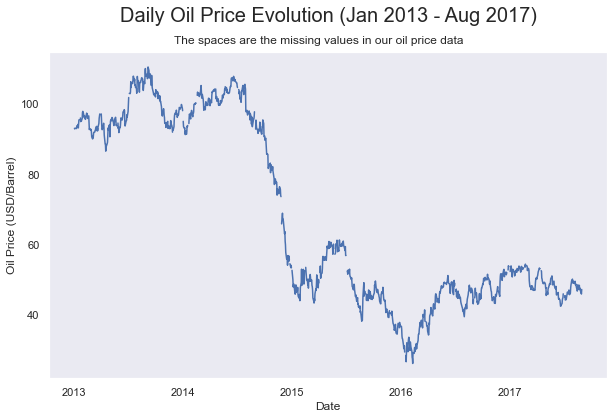

In [45]:
# for the oil prices we will first check the price evolution
plt.figure(figsize=(10,6))

#plot
plt.plot(oil.set_index('date'))

#design
plt.grid(False)
plt.title('Daily Oil Price Evolution (Jan 2013 - Aug 2017)', pad=30, size=20)
plt.figtext(.5,.90,'The spaces are the missing values in our oil price data',fontsize=12,ha='center')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD/Barrel)')

#saving and showing
plt.savefig('img/oilprice_evolution_missing_data.png', bbox_inches='tight',transparent=True)
plt.show()

In [46]:
#let's see what is the best way to fill in the missing data
check = oil.copy(deep=True)
check['price_ffill'] = check['price'].fillna(method='ffill')
check['price_linear'] = check['price'].interpolate(method='linear')
check['price_quadratic'] = check['price'].interpolate(method='quadratic')
check['price_nearest'] = check['price'].interpolate(method='nearest')
check[check['price'].isnull()].head()

,date,price,price_ffill,price_linear,price_quadratic,price_nearest
0,2013-01-01,NaN,NaN,NaN,NaN,NaN
14,2013-01-21,NaN,95.61,95.850,96.074277,95.61
34,2013-02-18,NaN,95.95,96.320,96.316158,95.95
63,2013-03-29,NaN,97.24,97.170,97.212118,97.24
104,2013-05-27,NaN,93.84,94.245,94.527430,93.84


In [47]:
#let's go for linear 
oil.price.interpolate(method='linear', inplace=True)

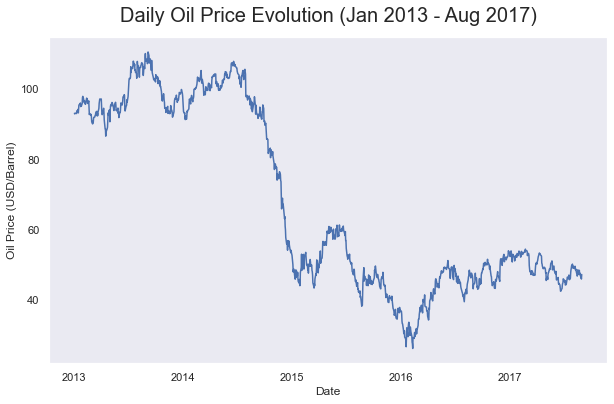

In [48]:
# for the oil prices we will first check the price evolution
plt.figure(figsize=(10,6))

#plot
plt.plot(oil.set_index('date'))

#design
plt.grid(False)
plt.title('Daily Oil Price Evolution (Jan 2013 - Aug 2017)', pad=15, size=20)
plt.xlabel('Date')
plt.ylabel('Oil Price (USD/Barrel)')

#saving and showing
plt.savefig('img/oilprice_evolution_interpolate_linear.png', bbox_inches='tight',transparent=True)
plt.show()

In [49]:
#we can also set the oil price for the weekend as the closing price for Friday
oil = oil.set_index('date').asfreq('d').fillna(method='ffill')

In [50]:
oil

,price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,93.12
...,...
2017-08-27,47.65
2017-08-28,46.40
2017-08-29,46.46


In [51]:
print('Nulls Oil dataset')
nulls(oil.iloc[1:,:]) #we skip the first value
print(' ')
print('Nulls Train dataset')
nulls(df)

Nulls Oil dataset
price 0.0%
 
Nulls Train dataset
id 0.0%
date 0.0%
store_nbr 0.0%
item_nbr 0.0%
unit_sales 0.0%
onpromotion 0.0%


We can see that there are no more null values

In [52]:
for name, data in dataframes.items():
    print(name.upper())
    print(data.shape)
    print()

TRAIN
(2562153, 6)

TEST
(62416, 5)

ITEMS
(3567, 4)

STORES
(54, 5)

HOLIDAYS
(173, 6)

OIL
(1218, 2)

TRANSACTIONS
(1676, 3)




## Saving the datasets
***

In [220]:
# finally, we save the new dataframe as a csv file.
